# Data analysis 4 - Lecture 2
This lecture is about storing and restoring model, application o fthe checkpoints.

We use validating sets, and evaluate our models on FashionMnist dataset.

Also we will try the TransferLearning simple/educational example where we use one model trained on a dataset and retrained only the final layer for different dataset.


[Open in Google colab](https://colab.research.google.com/github/jplatos/2019-2020-da4/blob/master/ds4_02.ipynb)
[Download from Github](https://raw.githubusercontent.com/jplatos/2019-2020-DA4/master/ds4_02.ipynb)


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import numpy as np #numpy
import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.preprocessing import normalize # normalization of the matrix

tf.version.VERSION

'2.0.0'

#### Some utility functions
Here is some functions we will use later several times
* **show_history** - show history of the **fit** method


In [2]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()


#### Dataset load
Importig dataset **FashonMinst** a collection of images 28x28 grayscale of typical clothes and accesories.
Dataset is:
* downloaded
* splitted into train and test set
* converted from the range <0,255> into <0, 1>
* *train* is splitted into *train* and *validation* set 
* class names are defined

In [3]:
# mnist is the basic dataset with handwritten digits
dataset = tf.keras.datasets.fashion_mnist

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

train_x, test_x = train_x/255.0, test_x/255.0

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# the data are in the form of 28x28 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boo']
class_count = len(class_names)
print('Class count:', class_count, class_names)

4423680/4422102 [==============================] - 1s 0us/step
Train data shape:  (48000, 28, 28) (48000,)
Validation data shape:  (12000, 28, 28) (12000,)
Test data shape:   (10000, 28, 28) (10000,)
Class count: 10 ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boo']


#### Show first 25 images from the dataset

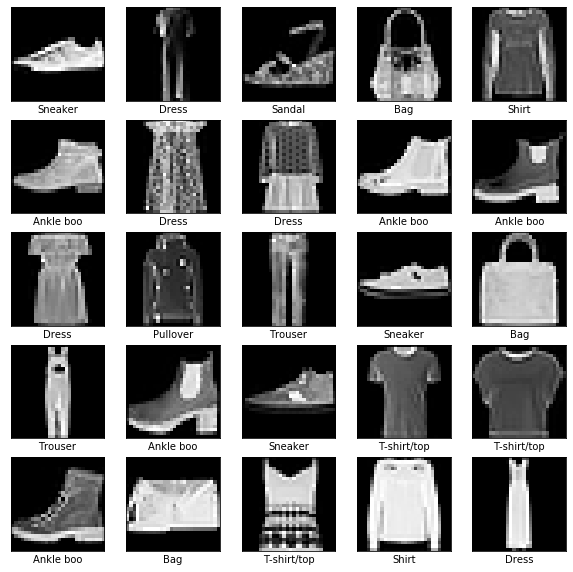

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i], cmap=plt.cm.gray)
    plt.xlabel(class_names[train_y[i]])
plt.show()

#### Definition of the model
The base model is defined as *Sequential* with three layers, similarly to the previous lecture.

Summarization of the model and compilation is done similarly as well.

In [5]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),# Flatten module flatten the multidimension input into single vector 28x28 = 784 float numbers
    keras.layers.Dense(32, activation=tf.nn.relu), # standard dense-fully connected layer with the rectified lineaar function as an activation
    keras.layers.Dense(class_count, activation=tf.nn.softmax), # another fully-connected layer with softmax activation function
])

model.summary()


model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


#### Fit the model for defined number of epochs.
Show the history of learning, evaluate the efficiency of the model.

Test accuracy:  0.8707


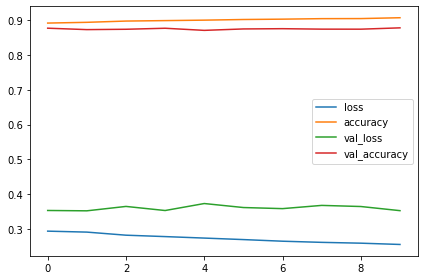

In [7]:
history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=10)

show_history(history)

test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

#### Vizualisation of the evaluation
The function *predict* return the prediction for the defined input - a test set.

The prediction in this case is a vector of probabilities foe each class.


In [8]:
predictions = model.predict(test_x)

print(predictions[0], np.argmax(predictions[0]))

[4.9403308e-09 1.0580614e-11 4.4975229e-07 8.6243963e-06 2.6070457e-11
 1.0619634e-02 1.1090785e-06 8.6111844e-02 1.4656971e-05 9.0324366e-01] 9


#### Vizualization of the confusion matrix.

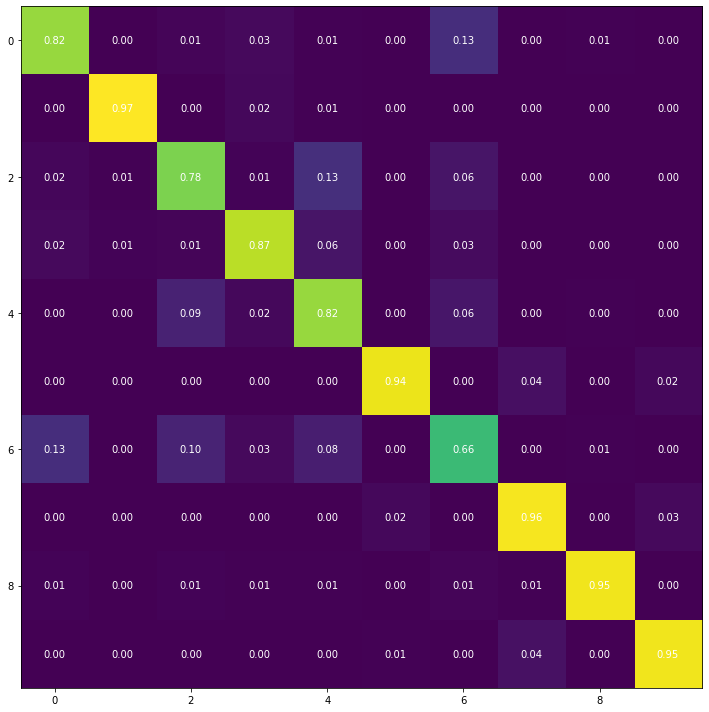

In [9]:
conf_matrix = np.zeros((class_count, class_count))
for idx, pred in enumerate(predictions):
    row = test_y[idx]
    col = np.argmax(pred)
    conf_matrix[row, col] += 1


# print(conf_matrix)
conf_matrix = normalize(conf_matrix, axis=1, norm='l1')
# print(conf_matrix)

plt.figure(figsize=(class_count,class_count))

plt.imshow(conf_matrix)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text = plt.text(j, i, "{:.2f}".format(conf_matrix[i, j]), ha="center", va="center", color="w")

plt.tight_layout()
plt.show()     

### Save and Load of the model
The model I/O works as follows. The topology of the model is usually stored separately from the weights. The reason is that the topology is usually used once, but the weights are used frequently and their develop during the learning process. 

The topology is stored as JSON file format, as is demonstrated later in more human readable form. As you may see, the document os very simple and just summarize the layers and its types - app parameters set during the model creation.

The weights are stored using the HDF5 file format a format developed for fast unlimited storage with portable and distributable capabilities. 

In [10]:
file_model = 'out/model.json'
file_weight = 'out/model.h5'

# serialize model to JSON
model_json = model.to_json()
with open(file_model, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(file_weight)
print("Saved model to disk")

Saved model to disk


```json
{
    "class_name": "Sequential",
    "config": {
        "name": "sequential",
        "layers": [
            {
                "class_name": "Flatten",
                "config": {
                    "name": "flatten",
                    "trainable": true,
                    "batch_input_shape": [
                        null,
                        28,
                        28
                    ],
                    "dtype": "float32",
                    "data_format": "channels_last"
                }
            },
            {
                "class_name": "Dense",
                "config": {
                    "name": "dense",
                    "trainable": true,
                    "dtype": "float32",
                    "units": 32,
                    "activation": "relu",
                    "use_bias": true,
                    "kernel_initializer": {
                        "class_name": "GlorotUniform",
                        "config": {
                            "seed": null
                        }
                    },
                    "bias_initializer": {
                        "class_name": "Zeros",
                        "config": {}
                    },
                    "kernel_regularizer": null,
                    "bias_regularizer": null,
                    "activity_regularizer": null,
                    "kernel_constraint": null,
                    "bias_constraint": null
                }
            },
            {
                "class_name": "Dense",
                "config": {
                    "name": "dense_1",
                    "trainable": true,
                    "dtype": "float32",
                    "units": 10,
                    "activation": "softmax",
                    "use_bias": true,
                    "kernel_initializer": {
                        "class_name": "GlorotUniform",
                        "config": {
                            "seed": null
                        }
                    },
                    "bias_initializer": {
                        "class_name": "Zeros",
                        "config": {}
                    },
                    "kernel_regularizer": null,
                    "bias_regularizer": null,
                    "activity_regularizer": null,
                    "kernel_constraint": null,
                    "bias_constraint": null
                }
            }
        ]
    },
    "keras_version": "2.2.4-tf",
    "backend": "tensorflow"
}
```

### Loading model
The model is also loadable separatelly. Topology and weights. 

In [11]:
# load json and create model
json_file = open('out/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("out/model.h5")
print("Loaded model from disk")

Loaded model from disk


The model need to be compiled to be applicable to the data.As you may see the summary of the model is the same as was for the previous one.

In [12]:
loaded_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


Evaluation of the model has the same results like the stored one.

In [13]:
test_loss, test_acc = loaded_model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

Test accuracy:  0.8707


## Tasks for Lecture 
1. THe task here will be focused on the usage of some [CallBacks](https://keras.io/callbacks/) from the keras API which is intended to monitor learning process. The major ones are *ModelCheckpoint* and *EarlyStopping*.
2. [Transfer learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a) is a method for reusing a prepared model from some type of dataset to new dataset. The usage of that model has many advantages. Lets go throug the link attached and read the description.
   * The problem will be demonstrated in the MNIST dataset (from the previous lecture).
   * The model trained on the FashionMnist will be reused on the Mnist dataset.
   * The first layers will be deactivated for training and model will be compiled.
   * The last layer will be trained on the new dataset and the result uses the knowledge from the previous learning.
3. Desing a model which will be able to classify **FashionMnist** with accuracy higher than **92%**.

In [15]:

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),# Flatten module flatten the multidimension input into single vector 28x28 = 784 float numbers
    keras.layers.Dense(32, activation=tf.nn.relu), # standard dense-fully connected layer with the rectified lineaar function as an activation
    keras.layers.Dense(class_count, activation=tf.nn.softmax), # another fully-connected layer with softmax activation function
])

model.summary()


model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [20]:
checkopointCallback = keras.callbacks.ModelCheckpoint('out/', 
                                                      monitor='val_loss', 
                                                      verbose=0, 
                                                      save_best_only=False, 
                                                      save_weights_only=True, 
                                                      mode='auto', 
                                                      period=1)

history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=5, callbacks=[checkopointCallback])

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 4s 80us/sample - loss: 0.3649 - accuracy: 0.8700 - val_loss: 0.3921 - val_accuracy: 0.8618
Epoch 2/5
48000/48000 [==============================] - 4s 78us/sample - loss: 0.3511 - accuracy: 0.8749 - val_loss: 0.3898 - val_accuracy: 0.8611
Epoch 3/5
48000/48000 [==============================] - 4s 85us/sample - loss: 0.3358 - accuracy: 0.8795 - val_loss: 0.3796 - val_accuracy: 0.8652
Epoch 4/5
48000/48000 [==============================] - 4s 82us/sample - loss: 0.3269 - accuracy: 0.8818 - val_loss: 0.3711 - val_accuracy: 0.8685
Epoch 5/5
48000/48000 [==============================] - 5s 96us/sample - loss: 0.3166 - accuracy: 0.8856 - val_loss: 0.3696 - val_accuracy: 0.8715
